# Importing the Libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle
from random import randint
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

c:\Users\Pedro\OneDrive - Instituto Maua de Tecnologia\5e_encounter_predictor\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining functions

In [2]:
COLORS = ['#8c1b3f','#fe0151', '#0c7ff4', '#3eb1ff']
CMAP = LinearSegmentedColormap.from_list('my_cmap', COLORS)

def print_classification_report(y_test, x_test, model, title):
    title = f'Classification Report - {title}'
    print(title+'\n')
    test = str(classification_report(y_test, model.predict(x_test)))
    test.split('\n')
    for line in test.split('\n'):
        print(line)
    print(f'ROC AUC Score: {round(roc_auc_score(y_test, model.predict_proba(x_test)[:,1]), 4)}')

def plot_heatmap(x_test, y_test, model, title):
    plt.figure(figsize=(8, 6))

    sns.heatmap(confusion_matrix(
        y_test, 
        model.predict(x_test), 
        normalize='true'), 
        annot=True, 
        fmt='.4f', 
        xticklabels=['No TPK', 'TPK'],  # type: ignore
        yticklabels=['No TPK', 'TPK'],  # type: ignore
        annot_kws={
            'fontsize': 16, 
            'fontweight': 'bold'},
        cmap=CMAP
        )
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('Actual', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(f'Confusion Matrix - {title}', fontsize=22)

def plot_roc_curve(X_test, Y_test, X_train, Y_train, model, title):
    curva_test = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
    curva_train = roc_curve(Y_train, model.predict_proba(X_train)[:,1])
    fig = plt.figure(figsize=(10, 7))
    sns.lineplot(x=curva_test[0], y=curva_test[1], label=f'Test ROC Curve {round(roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]), 4)}', color='#fe0151', linewidth=2)
    sns.lineplot(x=curva_train[0], y=curva_train[1], label=f'Train ROC Curve {round(roc_auc_score(Y_train, model.predict_proba(X_train)[:,1]), 4)}', color='#0c7ff4', linewidth=2)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title(f'ROC Curve - {title}',fontsize=22)
    plt.legend(fontsize=14)
    plt.grid(True)

def plot_feature_importance(model, test_data):
    explaner = shap.TreeExplainer(model)
    shap_values = explaner.shap_values(test_data)
    shap.summary_plot(shap_values, test_data, plot_type="violin", max_display=10)
        
def scale_pos_weight_balancing(params, inicial_value, final_value, step, X_train, Y_train, X_test, Y_test):
    pesos = np.round(np.arange(inicial_value, final_value, step), 5)
    best = 0

    for i in pesos:
        params['scale_pos_weight'] = i

        xgb_optuna = XGBClassifier()
        xgb_optuna.set_params(**params)

        xgb_optuna.fit(X_train, Y_train)
        Y_pred = xgb_optuna.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred, normalize='true').ravel()
        if abs(tn - tp) <= 0.01:
            print(i)
            print_classification_report(Y_test, X_test, xgb_optuna, f'XGBoost - Scale Pos Weight = {i}')
            print()
            best = i
            
    print("Best scale_pos_weight (that balances the model towards the minority class): " + str(best))
    return best

def predict(model,test, y,normalizer):
    input_test = randint(0, len(test))
    row_input = pd.DataFrame(test.iloc[input_test]).T
    try:
        print_input = pd.DataFrame(normalizer.inverse_transform(row_input), columns=row_input.columns)
    except:
        print('ruim')
        print_input = row_input 
    print('Input: ')
    display(row_input)
    print(f'The combat was between 4 players level {print_input.players_level.values[0]} against {print_input.num_of_monsters.values[0]} monster(s) CR {print_input.monster_cr.values[0]}')
    print('Expected: ', y.iloc[input_test])
    print(type(row_input.values))
    print('Predicted: ', bool(model.predict(row_input.values)[0]))

# Importing the Dataset

In [3]:
df = pd.read_csv('../Data/results_v6.csv')
df.sample(5)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
18909,Cleric,16,15,2,Bard,15,14,2,Sorcerer,12,...,14,2,1,Enchanter Wizard,5.0,12,49,humanoid,0.512113,2
74145,Sorcerer,5,15,2,Fighter,8,18,2,Artificer,6,...,14,2,1,Spined Devil,2.0,13,22,fiend,0.847973,1
55794,Fighter,7,14,2,Wizzard,6,11,2,Barbarian,10,...,12,2,1,Shadow Mastiff,2.0,12,33,monstrosity,0.840499,1
13616,Cleric,39,13,3,Paladin,47,17,3,Rogue,30,...,14,3,10,Myconid Sprout,0.0,10,7,plant,0.972381,5
57636,Paladin,38,17,3,Druid,40,11,3,Ranger,36,...,12,3,10,Magma Mephit,0.5,11,22,elemental,0.000000,5


In [4]:
all_monsters = pd.read_csv('../Data/5e_monster_data_5eTools.csv')
all_monsters.sample(5)

,Unnamed: 0,name,hp,hp formula,hp special,ac,ac special,cr,str,dex,...,walk,fly,swim,burrow,climb,hover,size,alignment,type,source
615,615,Demogorgon,60,8d8 + 24,-,15,-,4,16,12,...,30,-,-,-,-,-,M,U,monstrosity,HftT
532,532,Orzhov Giant,84,8d10 + 40,-,18,-,6,23,13,...,40,-,-,-,-,-,L,LE,giant,GGR
1413,1413,Fire Elemental Myrmidon,123,19d8 + 38,-,18,-,7,13,18,...,40,-,-,-,-,-,M,N,elemental,MPMM
1544,1544,Tortle,22,4d8 + 4,-,17,-,1/4,15,10,...,30,-,-,-,-,-,M,A,humanoid,MPMM
218,218,Young Wereraven,7,2d6,-,12,-,2,10,15,...,-,-,-,-,-,-,S,LG,humanoid,CoS


In [5]:
df_test = pd.read_csv('../Data/test_sample.csv')
df_test.sample(5)

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
1122,Warlock,16,12,2,Barbarian,16,15,2,Monk,20,...,11,2,2,Peryton,2.000,13,33,monstrosity,0.830645,2
4451,Druid,26,11,3,Artificer,24,16,3,Druid,24,...,13,3,5,Spy,1.000,12,27,humanoid,0.118034,3
2869,Monk,19,14,2,Druid,12,16,2,Ranger,22,...,12,2,10,Badger,0.000,10,3,beast,1.000000,2
2811,Monk,33,13,3,Wizzard,16,14,3,Rogue,30,...,12,3,5,Imp,1.000,13,10,fiend,0.419299,4
1002,Fighter,28,18,3,Paladin,35,14,3,Barbarian,33,...,16,3,10,Giant Rat,0.125,12,7,beast,0.787187,3


In [6]:
df_test_result = df_test['dificulty']==0
df_test_result.head()


0    False
1    False
2    False
3    False
4     True
Name: dificulty, dtype: bool

# Cleaning the Data

## Dropping miswrote data

In [7]:
df = df[df['p1_class'] != '22']
df = df[df['dificulty'] >= 0]
df = df[df['monster_cr'] != -1]
df = df[df['players_level'] <= 5]
print(df.shape)
df.head()

(102817, 24)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,14,3,1,Efreeti,11.00,17,200,elemental,0.869491,5
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,15,3,10,Giant Bat,0.25,13,22,beast,0.067640,3
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,2,1,Galeb Duhr,6.00,16,85,elemental,1.000000,2
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,13,3,1,Blue Slaad,7.00,15,123,aberration,0.285597,3
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,13,3,4,Lizardfolk Shaman,2.00,13,27,humanoid,0.445773,4


## Dropping unuseful columns

In [8]:
df['TPK'] = df['dificulty'] == 0
print(df.shape)
df.head()

(102817, 25)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level,TPK
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,3,1,Efreeti,11.00,17,200,elemental,0.869491,5,False
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,3,10,Giant Bat,0.25,13,22,beast,0.067640,3,False
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,2,1,Galeb Duhr,6.00,16,85,elemental,1.000000,2,False
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,3,1,Blue Slaad,7.00,15,123,aberration,0.285597,3,False
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,3,4,Lizardfolk Shaman,2.00,13,27,humanoid,0.445773,4,False


In [9]:
df_test.drop(columns=['dificulty'], inplace=True)
print(df_test.shape)
df_test.head()

(4488, 23)


,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,players_level
0,Fighter,10,18,2,Artificer,9,17,2,Cleric,6,...,8,18,2,1,Swarm of Quippers,1.00,13,28,beast,1
1,Paladin,40,18,3,Rogue,25,16,3,Fighter,37,...,57,17,3,1,Kraken Priest,5.00,15,75,monstrosity,5
2,Warlock,15,13,2,Ranger,17,16,2,Fighter,17,...,12,14,2,2,Quetzalcoatlus,2.00,13,30,beast,2
3,Monk,16,13,3,Monk,18,11,3,Paladin,26,...,30,12,3,1,Triceratops,5.00,13,95,beast,3
4,Wizzard,4,11,2,Paladin,11,15,2,Sorcerer,6,...,6,16,2,10,Duodrone,0.25,15,11,construct,1


## Adding the *size* column to df

In [10]:
all_monsters['monster_size'] = all_monsters['size']
all_monsters.drop(columns=['size'], inplace=True)

merged = df.merge(all_monsters[['name', 'monster_size']], left_on='monster_name', right_on='name', how='left')

merged.drop(columns=['name', 'monster_name','dificulty'], inplace=True)

merged.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131030 entries, 0 to 131029
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p1_class         131030 non-null  object 
 1   p1_hp            131030 non-null  int64  
 2   p1_ac            131030 non-null  int64  
 3   p1_avg_save      131030 non-null  int64  
 4   p2_class         131030 non-null  object 
 5   p2_hp            131030 non-null  int64  
 6   p2_ac            131030 non-null  int64  
 7   p2_avg_save      131030 non-null  int64  
 8   p3_class         131030 non-null  object 
 9   p3_hp            131030 non-null  int64  
 10  p3_ac            131030 non-null  int64  
 11  p3_avg_save      131030 non-null  int64  
 12  p4_class         131030 non-null  object 
 13  p4_hp            131030 non-null  int64  
 14  p4_ac            131030 non-null  int64  
 15  p4_avg_save      131030 non-null  int64  
 16  num_of_monsters  131030 non-null  int6

In [11]:
merged_test = df_test.merge(all_monsters[['name', 'monster_size']], left_on='monster_name', right_on='name', how='left')

merged_test.drop(columns=['name', 'monster_name'], inplace=True)

merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5743 entries, 0 to 5742
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         5743 non-null   object 
 1   p1_hp            5743 non-null   int64  
 2   p1_ac            5743 non-null   int64  
 3   p1_avg_save      5743 non-null   int64  
 4   p2_class         5743 non-null   object 
 5   p2_hp            5743 non-null   int64  
 6   p2_ac            5743 non-null   int64  
 7   p2_avg_save      5743 non-null   int64  
 8   p3_class         5743 non-null   object 
 9   p3_hp            5743 non-null   int64  
 10  p3_ac            5743 non-null   int64  
 11  p3_avg_save      5743 non-null   int64  
 12  p4_class         5743 non-null   object 
 13  p4_hp            5743 non-null   int64  
 14  p4_ac            5743 non-null   int64  
 15  p4_avg_save      5743 non-null   int64  
 16  num_of_monsters  5743 non-null   int64  
 17  monster_cr    

### Dropping NaN values

In [12]:
merged.dropna(inplace=True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130856 entries, 0 to 131029
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p1_class         130856 non-null  object 
 1   p1_hp            130856 non-null  int64  
 2   p1_ac            130856 non-null  int64  
 3   p1_avg_save      130856 non-null  int64  
 4   p2_class         130856 non-null  object 
 5   p2_hp            130856 non-null  int64  
 6   p2_ac            130856 non-null  int64  
 7   p2_avg_save      130856 non-null  int64  
 8   p3_class         130856 non-null  object 
 9   p3_hp            130856 non-null  int64  
 10  p3_ac            130856 non-null  int64  
 11  p3_avg_save      130856 non-null  int64  
 12  p4_class         130856 non-null  object 
 13  p4_hp            130856 non-null  int64  
 14  p4_ac            130856 non-null  int64  
 15  p4_avg_save      130856 non-null  int64  
 16  num_of_monsters  130856 non-null  int64  
 

In [13]:
merged_test.dropna(inplace=True)
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5732 entries, 0 to 5742
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         5732 non-null   object 
 1   p1_hp            5732 non-null   int64  
 2   p1_ac            5732 non-null   int64  
 3   p1_avg_save      5732 non-null   int64  
 4   p2_class         5732 non-null   object 
 5   p2_hp            5732 non-null   int64  
 6   p2_ac            5732 non-null   int64  
 7   p2_avg_save      5732 non-null   int64  
 8   p3_class         5732 non-null   object 
 9   p3_hp            5732 non-null   int64  
 10  p3_ac            5732 non-null   int64  
 11  p3_avg_save      5732 non-null   int64  
 12  p4_class         5732 non-null   object 
 13  p4_hp            5732 non-null   int64  
 14  p4_ac            5732 non-null   int64  
 15  p4_avg_save      5732 non-null   int64  
 16  num_of_monsters  5732 non-null   int64  
 17  monster_cr       57

# Exploring the Data

## Plotting the data

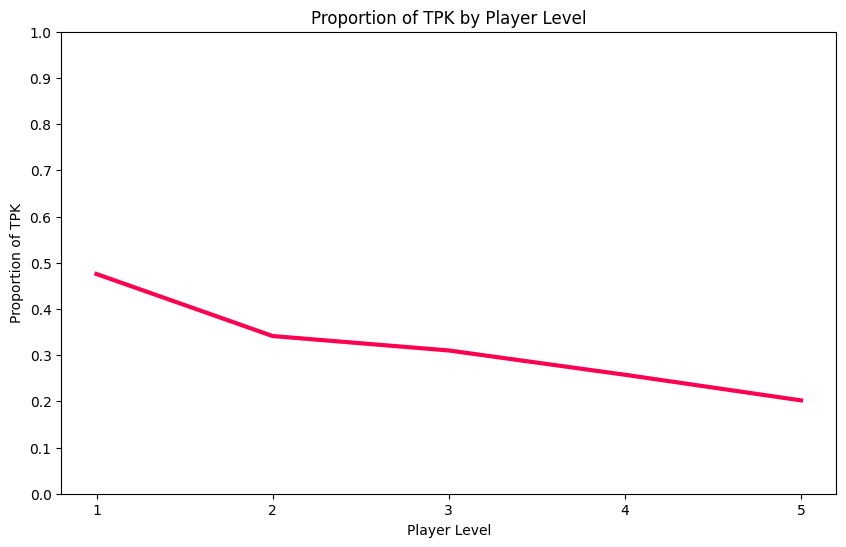

In [14]:
ticks = ticks = (merged.players_level.unique().tolist())
tpk_proportion = merged.groupby('players_level')['TPK'].mean()
tpk_proportion.plot(kind='line', figsize=(10, 6), color=COLORS[1],linewidth=3)
plt.title('Proportion of TPK by Player Level')
plt.xlabel('Player Level')
plt.ylabel('Proportion of TPK')
plt.xticks(ticks=ticks,rotation=0)
plt.yticks(ticks=[i/10 for i in range(11)],rotation=0)
plt.show()

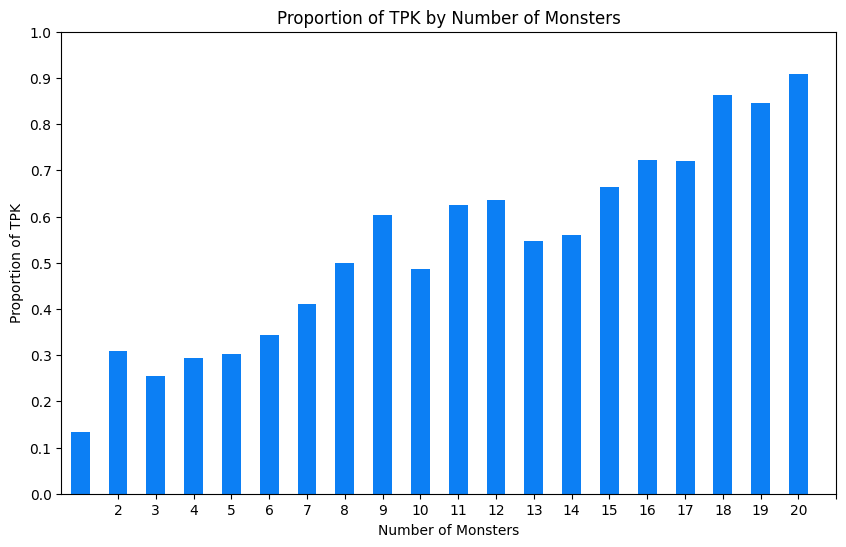

In [15]:
ticks = (merged.num_of_monsters.unique().tolist())

tpk_proportion = merged.groupby('num_of_monsters')['TPK'].mean()
tpk_proportion.plot(kind='bar', figsize=(10, 6), color=COLORS[2], linewidth=3)
plt.title('Proportion of TPK by Number of Monsters')
plt.xlabel('Number of Monsters')
plt.ylabel('Proportion of TPK')
plt.xticks(ticks=ticks,rotation=0)
plt.yticks(ticks=[i/10 for i in range(11)],rotation=0)
plt.show()


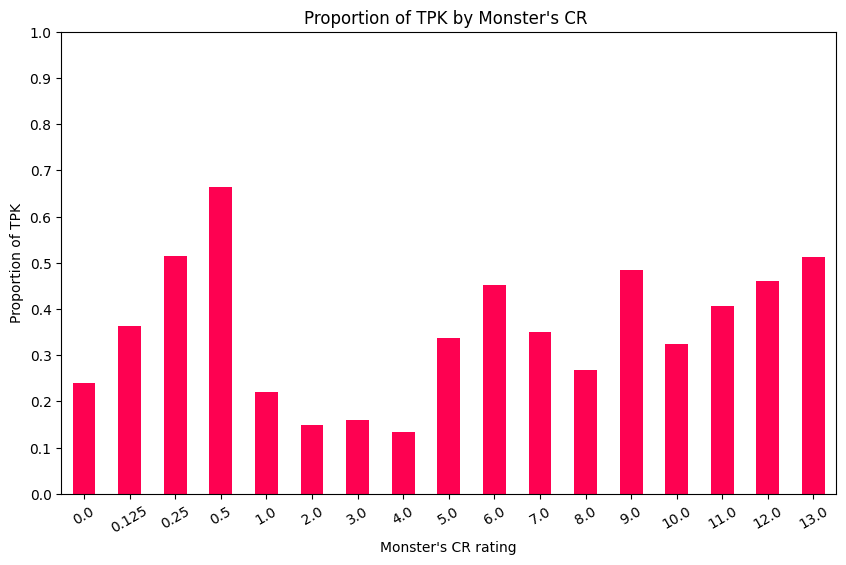

In [16]:
tpk_proportion = merged.groupby('monster_cr')['TPK'].mean()
tpk_proportion.plot(kind='bar', figsize=(10, 6), color=COLORS[1])

plt.title("Proportion of TPK by Monster's CR ")
plt.xlabel("Monster's CR rating")
plt.ylabel('Proportion of TPK')
plt.xticks(rotation=30)
plt.yticks(ticks=[i/10 for i in range(11)],rotation=0)
plt.show()


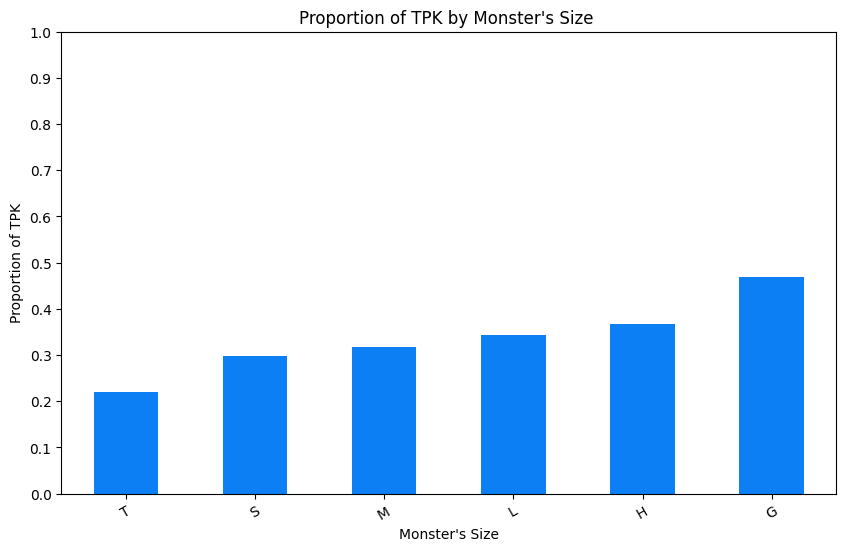

In [17]:
tpk_proportion = merged.groupby('monster_size')['TPK'].mean().sort_index(ascending=False)
tpk_proportion.plot(kind='bar', figsize=(10, 6), color=COLORS[2], linewidth=3)
plt.title("Proportion of TPK by Monster's Size ")
plt.xlabel("Monster's Size")
plt.ylabel('Proportion of TPK')
plt.xticks(rotation=30)
plt.yticks(ticks=[i/10 for i in range(11)],rotation=0)
plt.show()

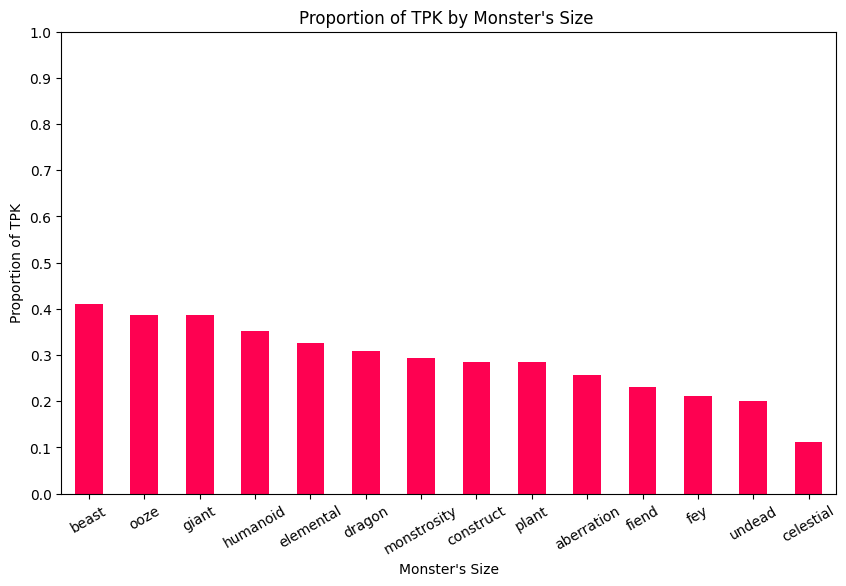

In [18]:
tpk_proportion = merged.groupby('monster_type')['TPK'].mean().sort_values(ascending=False)
tpk_proportion.plot(kind='bar', figsize=(10, 6), color=COLORS[1], linewidth=3)
plt.title("Proportion of TPK by Monster's Size ")
plt.xlabel("Monster's Size")
plt.ylabel('Proportion of TPK')
plt.xticks(rotation=30)
plt.yticks(ticks=[i/10 for i in range(11)],rotation=0)
plt.show()


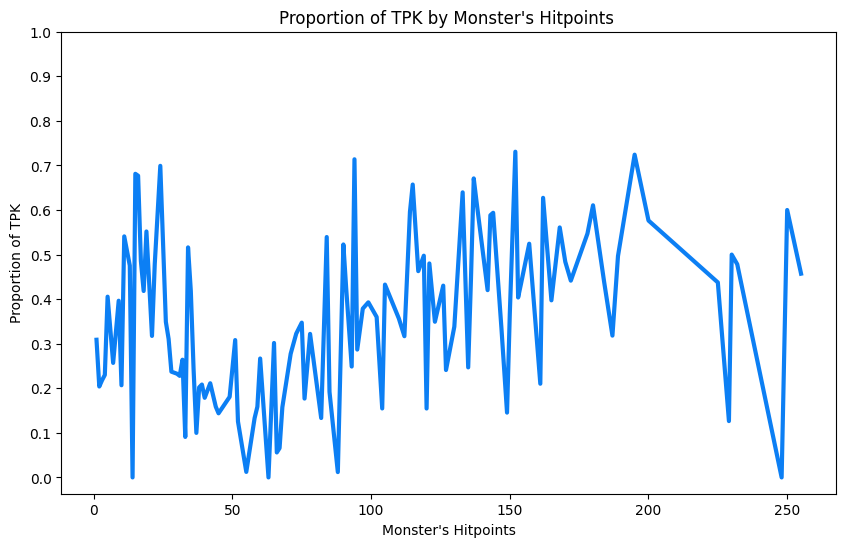

In [19]:
tpk_proportion = merged.groupby('monster_hp')['TPK'].mean()
tpk_proportion.plot(kind='line', figsize=(10, 6), color=COLORS[2], linewidth=3)
plt.title("Proportion of TPK by Monster's Hitpoints ")
plt.xlabel("Monster's Hitpoints")
plt.ylabel('Proportion of TPK')
plt.yticks(ticks=[i/10 for i in range(11)],rotation=0)
plt.show()

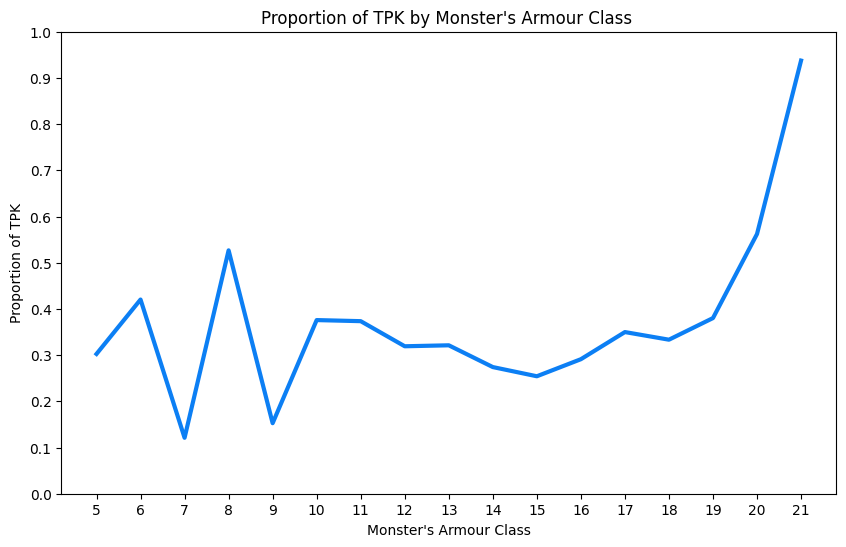

In [20]:
tpk_proportion = merged.groupby('monster_ac')['TPK'].mean()
tpk_proportion.plot(kind='line', figsize=(10, 6), color=COLORS[2], linewidth=3)
plt.title("Proportion of TPK by Monster's Armour Class ")
plt.xlabel("Monster's Armour Class")
plt.ylabel('Proportion of TPK')
plt.xticks(range(5,22),rotation=0)
plt.yticks(ticks=[i/10 for i in range(11)],rotation=0)
plt.show()

## Seeing the correlation between the data

### Correlation in regards to the target

In [21]:
corr_matrix = merged.corr(numeric_only=True)
abs(corr_matrix['TPK']).sort_values(ascending = False)

TPK                1.000000
num_of_monsters    0.311339
players_level      0.191285
p3_hp              0.191184
p2_hp              0.190314
p1_hp              0.190183
p4_hp              0.189687
p2_avg_save        0.159266
p3_avg_save        0.159266
p4_avg_save        0.159266
p1_avg_save        0.159266
p3_ac              0.042047
p1_ac              0.039822
p4_ac              0.039210
p2_ac              0.037009
monster_cr         0.029945
monster_ac         0.013132
monster_hp         0.004917
Name: TPK, dtype: float64

### Correlation in regards to each other

In [22]:
corr_matrix

,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,players_level,TPK
p1_hp,1.000000,0.099431,0.757196,0.769666,-0.002019,0.757196,0.768946,-0.001798,0.757196,0.769195,0.002149,0.757196,0.014771,0.322135,0.142304,0.292609,0.876989,-0.190183
p1_ac,0.099431,1.000000,0.003793,0.005721,0.004293,0.003793,0.007474,0.004043,0.003793,0.007221,-0.002089,0.003793,-0.003406,0.004627,0.002585,0.002859,0.006751,-0.039822
p1_avg_save,0.757196,0.003793,1.000000,0.758264,-0.000077,1.000000,0.758169,0.003353,1.000000,0.758239,0.002115,1.000000,0.018583,0.286783,0.129928,0.261042,0.864079,-0.159266
p2_hp,0.769666,0.005721,0.758264,1.000000,0.094601,0.758264,0.768584,-0.000928,0.758264,0.769653,0.002319,0.758264,0.012105,0.322929,0.142648,0.292065,0.876846,-0.190314
p2_ac,-0.002019,0.004293,-0.000077,0.094601,1.000000,-0.000077,-0.002632,0.002249,-0.000077,-0.002171,-0.001602,-0.000077,0.006466,-0.006692,-0.008533,-0.004638,-0.002869,-0.037009
p2_avg_save,0.757196,0.003793,1.000000,0.758264,-0.000077,1.000000,0.758169,0.003353,1.000000,0.758239,0.002115,1.000000,0.018583,0.286783,0.129928,0.261042,0.864079,-0.159266
p3_hp,0.768946,0.007474,0.758169,0.768584,-0.002632,0.758169,1.000000,0.093173,0.758169,0.769166,0.001850,0.758169,0.011525,0.324311,0.143464,0.293206,0.876573,-0.191184
p3_ac,-0.001798,0.004043,0.003353,-0.000928,0.002249,0.003353,0.093173,1.000000,0.003353,-0.000846,-0.002581,0.003353,-0.004461,0.003256,-0.000415,0.002029,-0.001969,-0.042047
p3_avg_save,0.757196,0.003793,1.000000,0.758264,-0.000077,1.000000,0.758169,0.003353,1.000000,0.758239,0.002115,1.000000,0.018583,0.286783,0.129928,0.261042,0.864079,-0.159266
p4_hp,0.769195,0.007221,0.758239,0.769653,-0.002171,0.758239,0.769166,-0.000846,0.758239,1.000000,0.096326,0.758239,0.011609,0.326272,0.145080,0.296494,0.877174,-0.189687


# Sampling the data

## Dividing the data into variables and target sets

In [23]:
X = merged.drop(columns=['TPK'], axis=1)
Y = merged['TPK']

## One hot encoding

In [24]:
encoder_class = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

features_df = encoder_class.fit_transform(X[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size']]) # type: ignore
X_encoded = pd.concat([X, features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size'])
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130856 entries, 0 to 131029
Data columns (total 89 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p1_hp                     130856 non-null  int64  
 1   p1_ac                     130856 non-null  int64  
 2   p1_avg_save               130856 non-null  int64  
 3   p2_hp                     130856 non-null  int64  
 4   p2_ac                     130856 non-null  int64  
 5   p2_avg_save               130856 non-null  int64  
 6   p3_hp                     130856 non-null  int64  
 7   p3_ac                     130856 non-null  int64  
 8   p3_avg_save               130856 non-null  int64  
 9   p4_hp                     130856 non-null  int64  
 10  p4_ac                     130856 non-null  int64  
 11  p4_avg_save               130856 non-null  int64  
 12  num_of_monsters           130856 non-null  int64  
 13  monster_cr                130856 non-null  float6

In [25]:
test_features_df = encoder_class.transform(merged_test[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size']]) # type: ignore
df_test_encoded = pd.concat([merged_test, test_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size'])
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5732 entries, 0 to 5742
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p1_hp                     5732 non-null   int64  
 1   p1_ac                     5732 non-null   int64  
 2   p1_avg_save               5732 non-null   int64  
 3   p2_hp                     5732 non-null   int64  
 4   p2_ac                     5732 non-null   int64  
 5   p2_avg_save               5732 non-null   int64  
 6   p3_hp                     5732 non-null   int64  
 7   p3_ac                     5732 non-null   int64  
 8   p3_avg_save               5732 non-null   int64  
 9   p4_hp                     5732 non-null   int64  
 10  p4_ac                     5732 non-null   int64  
 11  p4_avg_save               5732 non-null   int64  
 12  num_of_monsters           5732 non-null   int64  
 13  monster_cr                5732 non-null   float64
 14  monster_ac   

In [26]:
print(len(Y))
print(len(X_encoded))

130856
130856


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=7)

# Building the Model

## Making a rough model, without any hyperparameter tuning

### Training the model

In [28]:
clfXGB = XGBClassifier(eval_metric='auc')
clfXGB.fit( X_train,
            Y_train,
            verbose=20,
            eval_set=[(X_train, Y_train),(X_test, Y_test)],
            );

[0]	validation_0-auc:0.88070	validation_1-auc:0.87705
[20]	validation_0-auc:0.95122	validation_1-auc:0.94438
[40]	validation_0-auc:0.96890	validation_1-auc:0.95869
[60]	validation_0-auc:0.97818	validation_1-auc:0.96687
[80]	validation_0-auc:0.98414	validation_1-auc:0.97217
[99]	validation_0-auc:0.98784	validation_1-auc:0.97580


### Looking at the model results

In [29]:
title = 'Plain XGBoost'

#### Confusion matrix

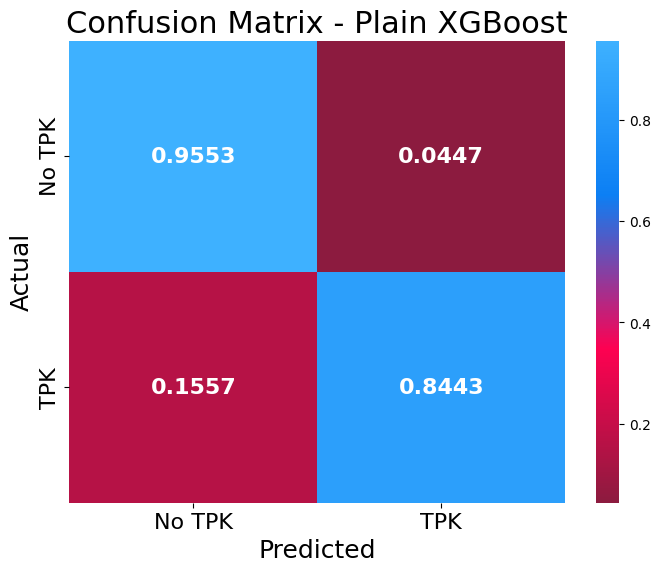

In [31]:
plot_heatmap(X_test,Y_test, clfXGB, title);

#### Classification report

In [32]:
print_classification_report(Y_test,X_test,clfXGB, title)

Classification Report - Plain XGBoost

              precision    recall  f1-score   support

       False       0.93      0.96      0.94     17946
        True       0.90      0.84      0.87      8226

    accuracy                           0.92     26172
   macro avg       0.91      0.90      0.91     26172
weighted avg       0.92      0.92      0.92     26172

ROC AUC Score: 0.9758


#### Feature importance

[15:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


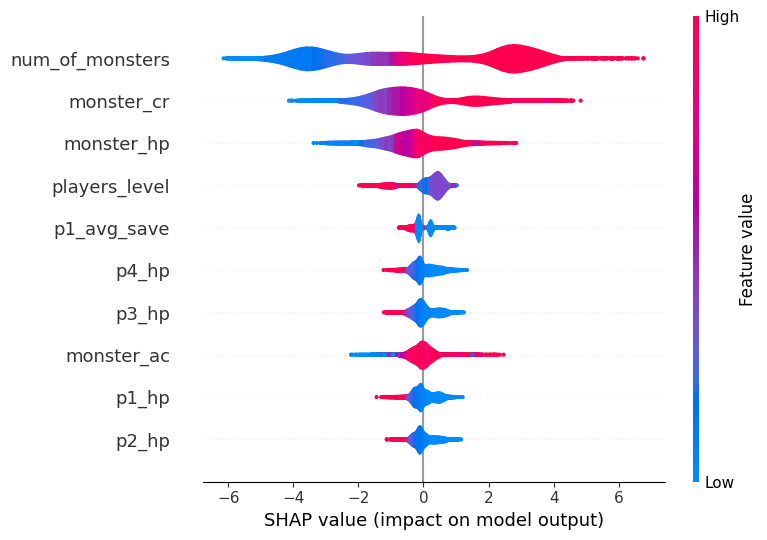

In [33]:
plot_feature_importance(clfXGB, X_test)

#### Plotting the ROC curve

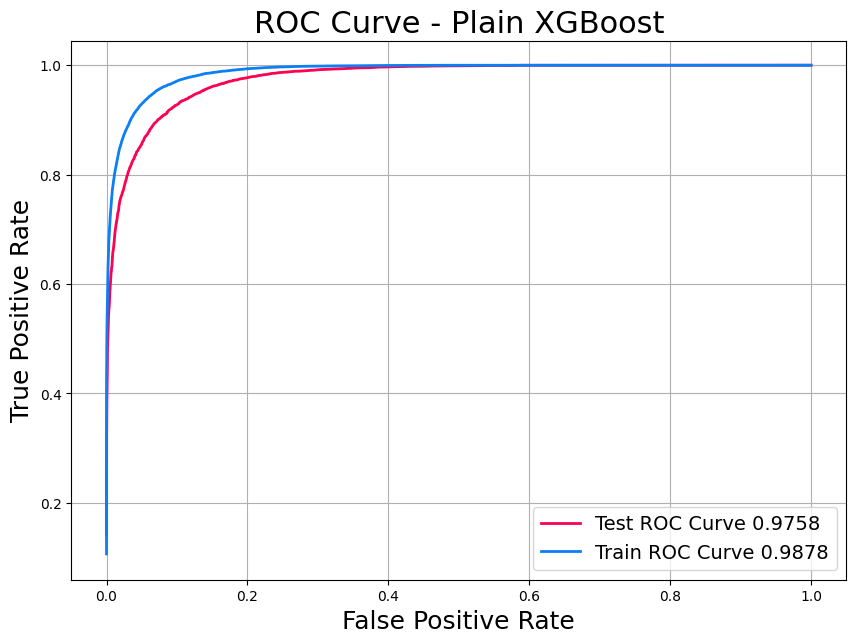

In [34]:
plot_roc_curve(X_test, Y_test, X_train, Y_train, clfXGB, title)

## Tuning the hyperparameters using ``Optuna``

### Defining the objective function

In [35]:
skf = StratifiedKFold(10, shuffle=True, random_state=7)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=7, n_jobs=-1)

    return cross_val_score(cls, X_train, Y_train,
                           cv=skf, scoring='accuracy').mean()

### Training the model while tuning the hyperparameters

In [36]:
studyXGB = optuna.create_study(direction='maximize', study_name='classification')
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)
studyXGB.best_params

[I 2023-12-14 15:31:44,321] A new study created in memory with name: classification
[I 2023-12-14 15:32:12,471] Trial 7 finished with value: 0.8395074365341524 and parameters: {'n_estimators': 62, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.3, 'min_child_weight': 5, 'colsample_bytree': 0.7}. Best is trial 7 with value: 0.8395074365341524.
[I 2023-12-14 15:32:24,129] Trial 11 finished with value: 0.8494611682295232 and parameters: {'n_estimators': 92, 'max_depth': 3, 'learning_rate': 0.15000000000000002, 'gamma': 0.2, 'min_child_weight': 6, 'colsample_bytree': 0.7}. Best is trial 11 with value: 0.8494611682295232.
[I 2023-12-14 15:32:25,819] Trial 1 finished with value: 0.842430513319653 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'min_child_weight': 2, 'colsample_bytree': 0.4}. Best is trial 11 with value: 0.8494611682295232.
[I 2023-12-14 15:32:30,568] Trial 6 finished with value: 0.8606377078561509 and parameters: {'n_

{'n_estimators': 195,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 1,
 'colsample_bytree': 0.6000000000000001}

### Model best parameters

In [37]:
params = studyXGB.best_params
# params = {
#     'n_estimators': 195,
#     'max_depth': 7,
#     'learning_rate': 0.2,
#     'gamma': 0.2,
#     'min_child_weight': 1,
#     'colsample_bytree': 0.6000000000000001
# }

### Training the model with the best parameters

In [38]:
xgb_optuna = XGBClassifier(early_stopping_rounds=10, eval_metric='auc')
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, Y_train, verbose=20,eval_set=[(X_train, Y_train),(X_test, Y_test)]);

[0]	validation_0-auc:0.68141	validation_1-auc:0.67173
[20]	validation_0-auc:0.95294	validation_1-auc:0.94426
[40]	validation_0-auc:0.96653	validation_1-auc:0.95538
[60]	validation_0-auc:0.97669	validation_1-auc:0.96428
[80]	validation_0-auc:0.98300	validation_1-auc:0.96994
[100]	validation_0-auc:0.98709	validation_1-auc:0.97332
[120]	validation_0-auc:0.99008	validation_1-auc:0.97616
[140]	validation_0-auc:0.99219	validation_1-auc:0.97811
[160]	validation_0-auc:0.99365	validation_1-auc:0.97975
[180]	validation_0-auc:0.99534	validation_1-auc:0.98196
[194]	validation_0-auc:0.99607	validation_1-auc:0.98275


### Looking at the model results

In [39]:
title = 'XGBoost with Optuna'

#### Confusion matrix

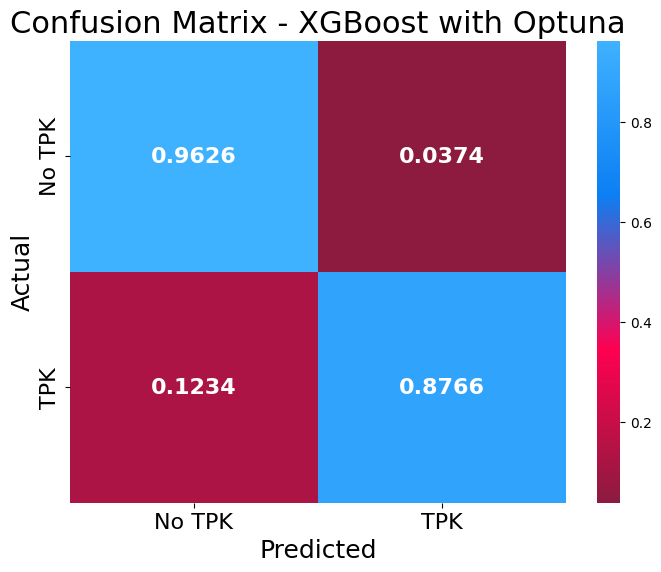

In [41]:
plot_heatmap(X_test,Y_test, xgb_optuna, title);

#### Printing the classification report

In [42]:
print_classification_report(Y_test,X_test,xgb_optuna, title)

Classification Report - XGBoost with Optuna

              precision    recall  f1-score   support

       False       0.94      0.96      0.95     17946
        True       0.91      0.88      0.90      8226

    accuracy                           0.94     26172
   macro avg       0.93      0.92      0.92     26172
weighted avg       0.94      0.94      0.94     26172

ROC AUC Score: 0.9828


#### Plotting the feature importance

[15:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


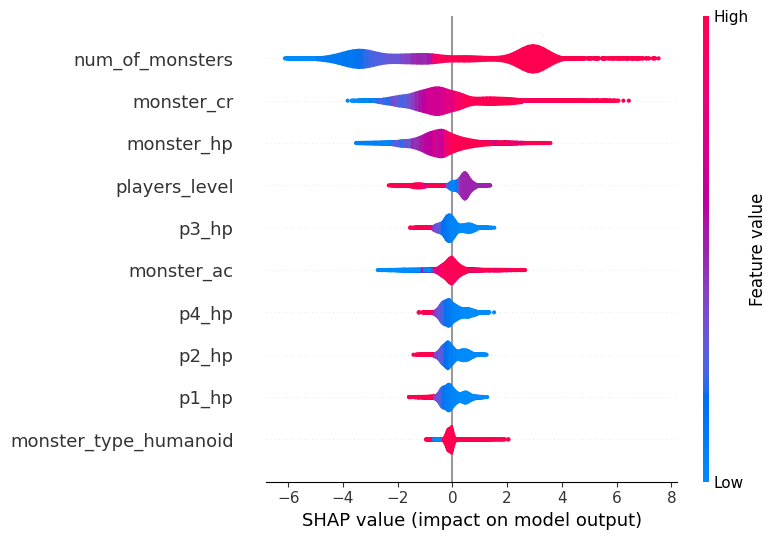

In [43]:
plot_feature_importance(xgb_optuna, X_test)

#### Plotting the ROC curve

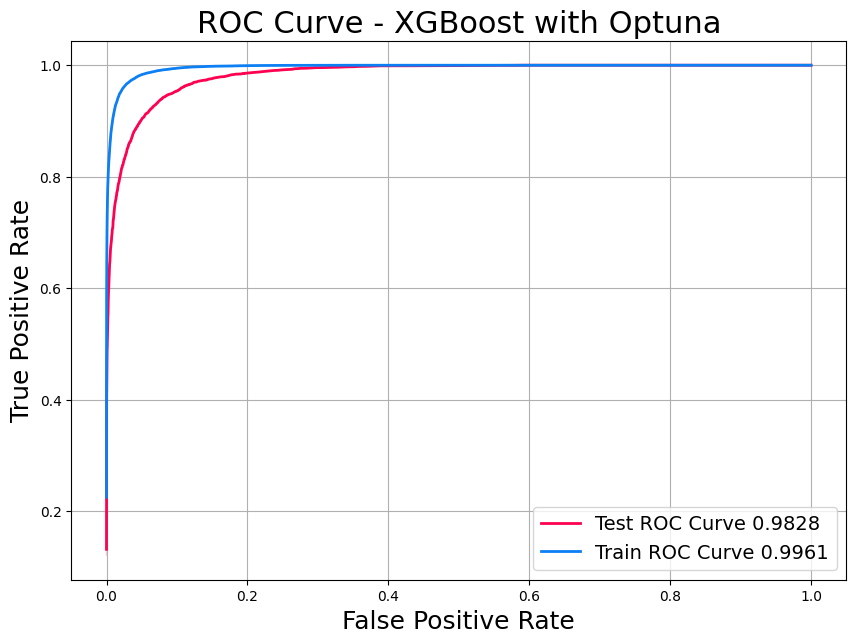

In [44]:
plot_roc_curve(X_test, Y_test, X_train, Y_train, xgb_optuna, title)

## Tuning the ``scale_pos_weight`` hyperparameter to balance the true negatives and true positives

### Tuning the ``scale_pos_weight`` 

In [45]:
params['scale_pos_weight'] = scale_pos_weight_balancing(params, 0.5, 3, 0.01, X_train, Y_train, X_test, Y_test)

1.87
Classification Report - XGBoost - Scale Pos Weight = 1.87

              precision    recall  f1-score   support

       False       0.97      0.94      0.95     17946
        True       0.87      0.93      0.90      8226

    accuracy                           0.93     26172
   macro avg       0.92      0.93      0.92     26172
weighted avg       0.94      0.93      0.93     26172

ROC AUC Score: 0.9829

1.91
Classification Report - XGBoost - Scale Pos Weight = 1.91

              precision    recall  f1-score   support

       False       0.97      0.94      0.95     17946
        True       0.87      0.93      0.90      8226

    accuracy                           0.93     26172
   macro avg       0.92      0.93      0.93     26172
weighted avg       0.94      0.93      0.93     26172

ROC AUC Score: 0.9834

1.92
Classification Report - XGBoost - Scale Pos Weight = 1.92

              precision    recall  f1-score   support

       False       0.97      0.94      0.95     17946

In [46]:
params['scale_pos_weight'] = 2.27

### Training the model with the best parameters

In [47]:
xgb_optuna = XGBClassifier(early_stopping_rounds=10, eval_metric='auc')
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, Y_train, verbose=20, eval_set=[(X_train, Y_train),(X_test, Y_test)]);

[0]	validation_0-auc:0.68241	validation_1-auc:0.67337
[20]	validation_0-auc:0.94947	validation_1-auc:0.94093
[40]	validation_0-auc:0.96672	validation_1-auc:0.95518
[60]	validation_0-auc:0.97621	validation_1-auc:0.96358
[80]	validation_0-auc:0.98281	validation_1-auc:0.96957
[100]	validation_0-auc:0.98805	validation_1-auc:0.97503
[120]	validation_0-auc:0.99093	validation_1-auc:0.97818
[140]	validation_0-auc:0.99272	validation_1-auc:0.97961
[160]	validation_0-auc:0.99469	validation_1-auc:0.98202
[180]	validation_0-auc:0.99581	validation_1-auc:0.98332
[194]	validation_0-auc:0.99641	validation_1-auc:0.98405


### Looking at the model results

In [48]:
title = 'XGBoost with Optuna \nand Scale Pos Weight'

#### Plotting the confusion matrix

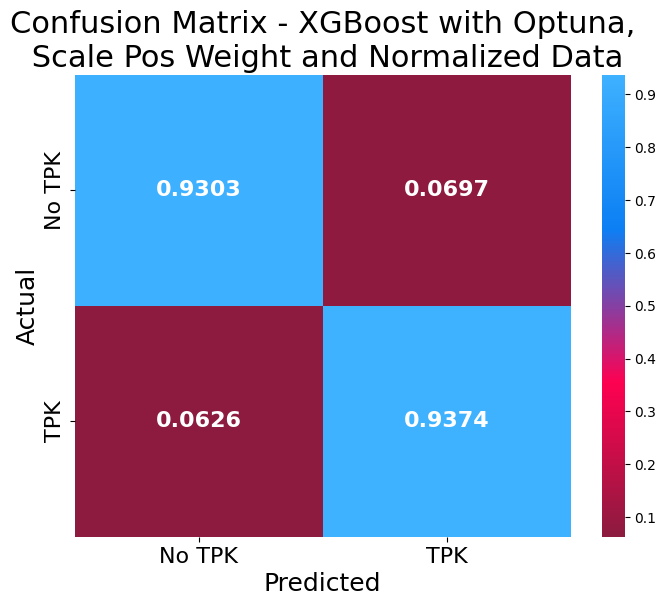

In [69]:
plot_heatmap(X_test,Y_test, xgb_optuna, title);

#### Printing the classification report

In [70]:
print_classification_report(Y_test,X_test,xgb_optuna, title)

Classification Report - XGBoost with Optuna,
 Scale Pos Weight and Normalized Data

              precision    recall  f1-score   support

       False       0.97      0.93      0.95     17946
        True       0.86      0.94      0.90      8226

    accuracy                           0.93     26172
   macro avg       0.92      0.93      0.92     26172
weighted avg       0.94      0.93      0.93     26172

ROC AUC Score: 0.984


#### Plotting the feature importance

[16:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


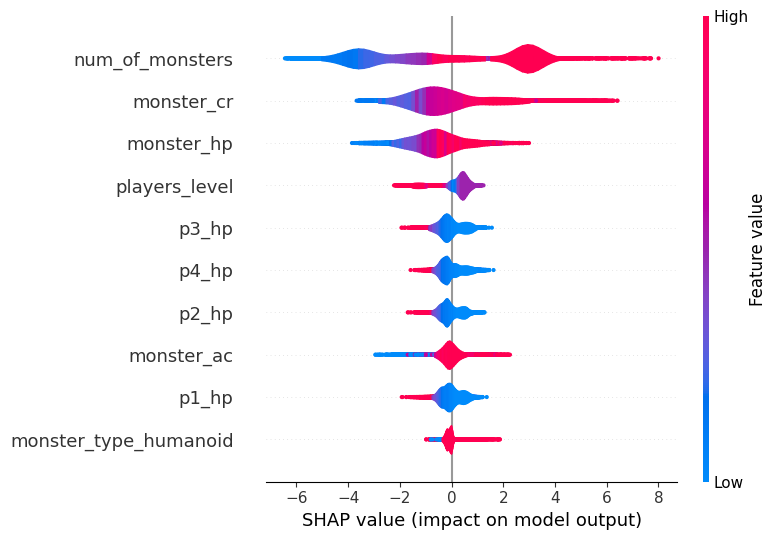

In [71]:
plot_feature_importance(xgb_optuna, X_test)

#### Plotting the ROC curve

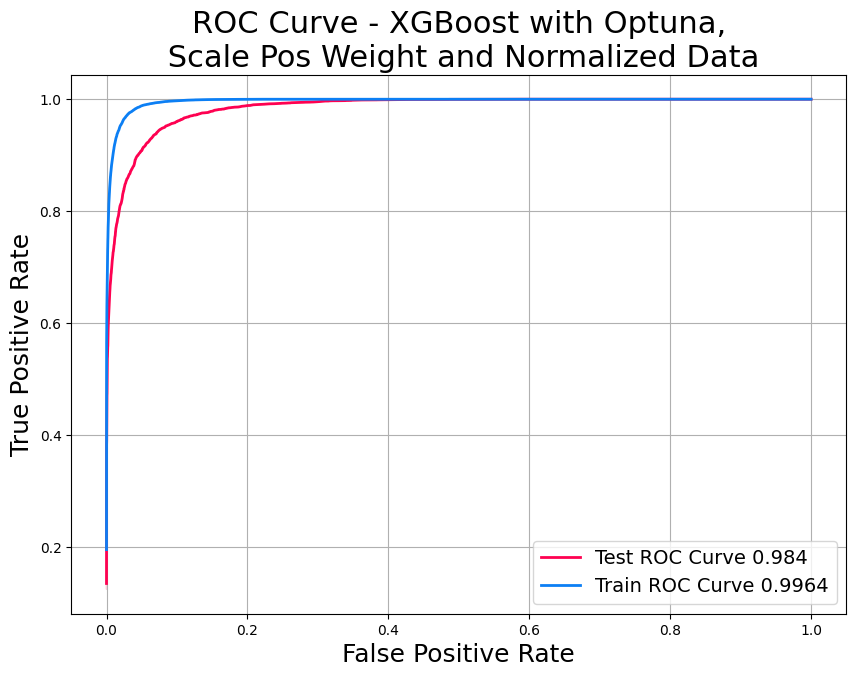

In [72]:
plot_roc_curve(X_test, Y_test, X_train, Y_train, xgb_optuna, title)

## Training a model with the best hyperparameters on normalized data

### Normalizing the data

#### Creating the normalizer object

In [54]:
from sklearn.preprocessing import MinMaxScaler

normalizer_class = MinMaxScaler()

#### Normalizing the data

In [55]:
X_encoded_normalized = normalizer_class.fit_transform(X_encoded)
X_encoded_normalized = pd.DataFrame(X_encoded_normalized, columns=X_encoded.columns)

#### Normalizing the test data

In [57]:
df_test_encoded_normalized = normalizer_class.transform(df_test_encoded)
df_test_encoded_normalized = pd.DataFrame(df_test_encoded_normalized, columns=df_test_encoded.columns)

### Splitting the data into training and validation sets

In [58]:
X_train_normalized, X_test_normalized, Y_train_normalized, Y_test_normalized = train_test_split(X_encoded_normalized, Y, test_size=0.2, random_state=7)

### Defining the objective function

In [59]:
skf = StratifiedKFold(10, shuffle=True, random_state=7)

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=7, n_jobs=-1)

    return cross_val_score(cls, X_train_normalized, Y_train_normalized,
                           cv=skf, scoring='accuracy').mean()

### Training the model while tuning the hyperparameters

In [60]:
studyXGB = optuna.create_study(direction='maximize', study_name='classification')
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)
studyXGB.best_params

[I 2023-12-14 15:58:17,877] A new study created in memory with name: classification
[I 2023-12-14 15:59:01,378] Trial 0 finished with value: 0.8463661643764168 and parameters: {'n_estimators': 88, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'min_child_weight': 3, 'colsample_bytree': 0.4}. Best is trial 0 with value: 0.8463661643764168.
[I 2023-12-14 15:59:01,578] Trial 4 finished with value: 0.8717187036508939 and parameters: {'n_estimators': 71, 'max_depth': 5, 'learning_rate': 0.15000000000000002, 'gamma': 0.3, 'min_child_weight': 6, 'colsample_bytree': 0.7}. Best is trial 4 with value: 0.8717187036508939.
[I 2023-12-14 15:59:06,214] Trial 11 finished with value: 0.8841847601593044 and parameters: {'n_estimators': 69, 'max_depth': 6, 'learning_rate': 0.15000000000000002, 'gamma': 0.1, 'min_child_weight': 6, 'colsample_bytree': 0.7}. Best is trial 11 with value: 0.8841847601593044.
[I 2023-12-14 15:59:21,343] Trial 9 finished with value: 0.8951511354756532 and parameters: {'n_

{'n_estimators': 200,
 'max_depth': 6,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 3,
 'colsample_bytree': 0.6000000000000001}

### Model best parameters

In [62]:
params = studyXGB.best_params
# params = {
#     'n_estimators': 200,
#     'max_depth': 6,
#     'learning_rate': 0.2,
#     'gamma': 0.2,
#     'min_child_weight': 3,
#     'colsample_bytree': 0.6000000000000001
#  }

### Tuning the ``scale_pos_weight`` 

In [63]:
params['scale_pos_weight'] = scale_pos_weight_balancing(params, 0.5, 3, 0.01, X_train_normalized, Y_train_normalized, X_test_normalized, Y_test_normalized)

1.79
Classification Report - XGBoost - Scale Pos Weight = 1.79

              precision    recall  f1-score   support

       False       0.96      0.93      0.94     17946
        True       0.85      0.92      0.89      8226

    accuracy                           0.93     26172
   macro avg       0.91      0.92      0.91     26172
weighted avg       0.93      0.93      0.93     26172

ROC AUC Score: 0.9797

1.83
Classification Report - XGBoost - Scale Pos Weight = 1.83

              precision    recall  f1-score   support

       False       0.96      0.93      0.94     17946
        True       0.85      0.92      0.88      8226

    accuracy                           0.92     26172
   macro avg       0.91      0.92      0.91     26172
weighted avg       0.93      0.92      0.92     26172

ROC AUC Score: 0.9793

1.86
Classification Report - XGBoost - Scale Pos Weight = 1.86

              precision    recall  f1-score   support

       False       0.96      0.93      0.94     17946

In [64]:
params['scale_pos_weight'] = 2.03

### Training the model with the best parameters

In [65]:
xgb_optuna_normalized = XGBClassifier(early_stopping_rounds=10, eval_metric='auc')
xgb_optuna_normalized.set_params(**params)

xgb_optuna_normalized.fit(X_train, Y_train, verbose=20,eval_set=[(X_train, Y_train),(X_test, Y_test)]);

[0]	validation_0-auc:0.67080	validation_1-auc:0.66278
[20]	validation_0-auc:0.93756	validation_1-auc:0.93191
[40]	validation_0-auc:0.95330	validation_1-auc:0.94550
[60]	validation_0-auc:0.96497	validation_1-auc:0.95618
[80]	validation_0-auc:0.97144	validation_1-auc:0.96166
[100]	validation_0-auc:0.97748	validation_1-auc:0.96707
[120]	validation_0-auc:0.98106	validation_1-auc:0.97021
[140]	validation_0-auc:0.98365	validation_1-auc:0.97236
[160]	validation_0-auc:0.98650	validation_1-auc:0.97549
[180]	validation_0-auc:0.98868	validation_1-auc:0.97744
[199]	validation_0-auc:0.99050	validation_1-auc:0.97967


### Looking at the model results

In [66]:
title = 'XGBoost with Optuna,\n Scale Pos Weight and Normalized Data'

### Plotting the confusion matrix

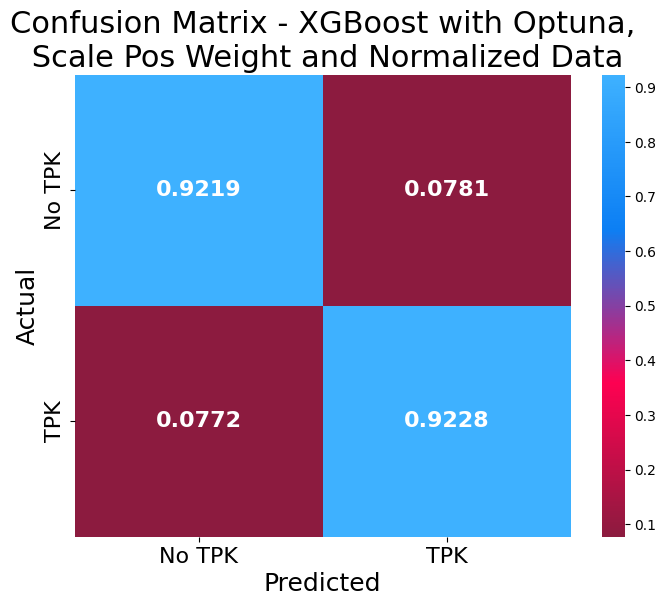

In [67]:
plot_heatmap(X_test,Y_test, xgb_optuna_normalized, title);

#### Printing the classification report

In [ ]:
print_classification_report(Y_test,X_test,xgb_optuna_normalized, title)

Classification Report - XGBoost with Optuna,
 Scale Pos Weight and Normalized Data

              precision    recall  f1-score   support

       False       0.96      0.91      0.93     13877
        True       0.83      0.92      0.87      6687

    accuracy                           0.91     20564
   macro avg       0.89      0.91      0.90     20564
weighted avg       0.92      0.91      0.91     20564

ROC AUC Score: 0.9754


#### Plotting the feature importance

[14:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


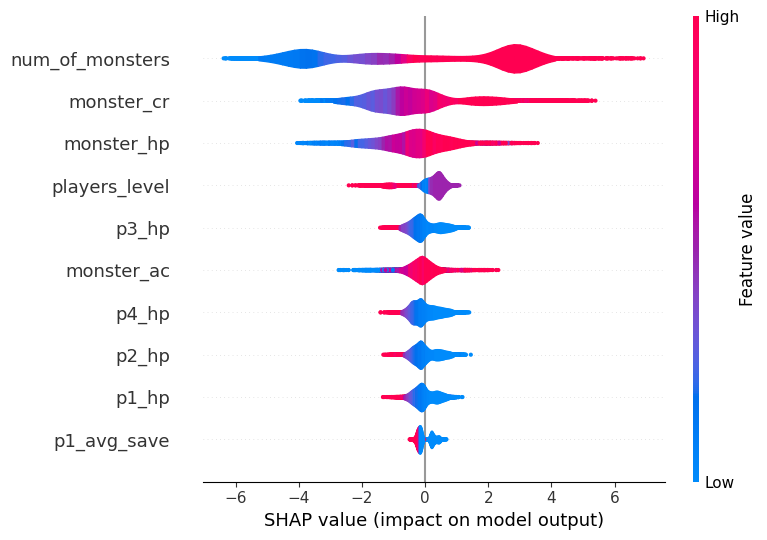

In [ ]:
plot_feature_importance(xgb_optuna_normalized, X_test);

#### Plotting the ROC curve

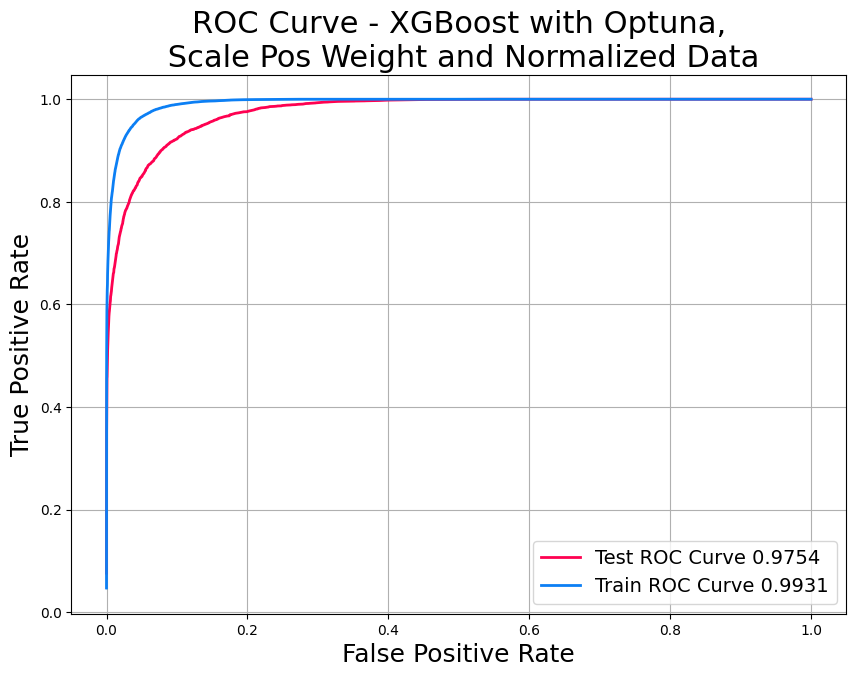

In [ ]:
plot_roc_curve(X_test, Y_test, X_train, Y_train, xgb_optuna_normalized, title)

# Saving the final model

In [108]:
xgb_optuna.save_model('model_opt_classification_v2.ubj')

# Making predictions on the test data

In [107]:
predict(xgb_optuna, df_test_encoded, df_test_result,None)

ruim
Input: 


,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead,monster_size_G,monster_size_H,monster_size_L,monster_size_M,monster_size_S,monster_size_T
1651,38.0,15.0,3.0,55.0,12.0,3.0,34.0,17.0,3.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


The combat was between 4 players level 5.0 against 17.0 monster(s) CR 1.0
Expected:  True
<class 'numpy.ndarray'>
Predicted:  True
